In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
import copy

from sklearn.linear_model import LinearRegression, LogisticRegression

'''
Super hacky plot making below
'''

# plt.ion()
# plt.figure(figsize=(10,7))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/app-root/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 2] No such file or directory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/opt/app-root/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: [Errno 2] No such file or directory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [7]:
torch.cuda.is_available()

True

In [3]:
def generate_data(N=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    features = []
    target = []

    for i in range(N):
        r = np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(0)

        r = 3 + np.random.uniform()
        theta = np.random.uniform(0, 2*np.pi)

        features.append([r*np.cos(theta), r*np.sin(theta)])
        target.append(1)

    features = np.array(features)
    target = np.array(target)

    return features, target

def simple_model(features, target, plot_decision=False):
    model = LogisticRegression()

    model.fit(features, target)

    pred = model.predict(features)

    accuracy = np.sum(pred==target)/float(len(target))
    print(f'Accuracy = {accuracy}')

    plt.clf()
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

    #u*x + v*y + w = 0
    # y = -w/v - u*x/v
    if plot_decision:
        x_vals, y_vals = [], []
        for x in [-4, 4]: #silly but don't worry
            y = (-1./model.coef_[0][1]) * (model.intercept_ + model.coef_[0][0] * x)

            x_vals.append(x)
            y_vals.append(y)

    plt.plot(x_vals, y_vals, label='decision boundary')
    plt.xlim(features[:,0].min(), features[:,0].max())
    plt.ylim(features[:,1].min(), features[:,1].max())

    if plot_decision:
        falsepred = np.where(pred!=target)[0]
        plt.plot(features[falsepred][:,0], features[falsepred][:,1], 'p', color='y', label='incorrect')
        plt.title(f'Logistic Regression - accuracy = {accuracy}')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=0)

    return model


Accuracy = 0.5365


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

/opt/app-root/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


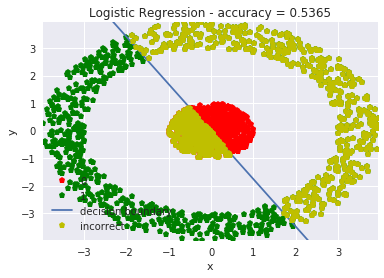

In [42]:
X, y = generate_data(seed=1022)
simple_model(X, y, True)

In [4]:
class Net(nn.Module):
    def __init__(self, N_input=2, N_output=1, N_hidden_layers=1, N_hidden_nodes=10):
        super(Net, self).__init__()

        self.linear1 = nn.Linear(N_input, N_hidden_nodes)
        self.hidden = nn.ModuleList([])
        for i in range(N_hidden_layers-1):
            self.hidden.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        self.linear2 = nn.Linear(N_hidden_nodes, N_output)  

        self.activation = nn.Sigmoid()
        self.output_activation = nn.Sigmoid()

    def forward(self, x):
        out = self.activation(self.linear1(x))
        for layer in self.hidden:
            out = self.activation(layer(out))
        out = self.output_activation(self.linear2(out))

        return out

def train_model(features, target, model, lr, N_epochs, shuffle=False):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model = model.to(device)
    features = features.to(device)
    target = target.to(device)

    for epoch in range(N_epochs):
        if shuffle: #should have no effect on gradients
            indices = torch.randperm(len(features))

            features_shuffled = features[indices]
            target_shuffled = target[indices]
        else:
            features_shuffled = features
            target_shuffled = target

        out = model(features_shuffled)
        loss = criterion(out, target_shuffled)

        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = model(features_shuffled).reshape(len(target))
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0

    accuracy = torch.sum(pred==target.reshape(len(target)))
    print(f'Accuracy = {accuracy}')

    model = model.to('cpu')
    features = features.to('cpu')
    target = target.to('cpu')

    return model

def introspect(features, target, model):
    '''Only if exactly 1 hidden layer -> draw decision boundaries and mark incorrect predictions
    '''
    params = list(model.parameters()) #small model
    
    weights = params[0].detach().numpy()
    biases = params[1].detach().numpy()

    #plot raw data
    features = copy.copy(features).detach().numpy()
    target = copy.copy(target).detach().numpy()

    plt.clf()
    plt.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    plt.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

    x_min, x_max = features[:,0].min(), features[:,0].max()
    y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
    for i in range(weights.shape[0]): #plot each decision boundary
        coef = weights[i]
        intercept = biases[i]

        #coef[0] * x + coef[1] * y + intercept = 0 -> decision boundary for sigmoid
        #y = (-intercept - coef[0]*x) / coef[1]
        y_min = (-intercept - coef[0]*x_min)/coef[1]
        y_max = (-intercept - coef[0]*x_max)/coef[1]

        plt.plot([x_min, x_max], [y_min, y_max])

    plt.xlim(x_min, x_max)
    plt.ylim(y_lim_min, y_lim_max)

    '''Plot inaccurate pred at threshold=0.5'''
    pred = model(torch.Tensor(features)).reshape(len(target)).detach().numpy()
    pred[pred<=0.5] = 0
    pred[pred>0.5] = 1

    labels = target.reshape(len(target))
    falsepred = np.where(pred!=labels)[0]

    plt.plot(features[falsepred][:,0], features[falsepred][:,1], 'p', color='y', label='incorrect')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(framealpha=0)
    plt.title(f'Decision boundaries for each node ({model.linear1.out_features}) in hidden layer')



def introspect_2hidden(features, target, model, plot_out_db=False):
    '''Hacky but okay
    Plots for input, db, second layer activations and second layer db
    '''
    params = list(model.parameters()) #small model
    
    features = copy.copy(features).detach().numpy()
    target = copy.copy(target).reshape(len(target)).detach().numpy()

    #plot original data
    fig = plt.figure()
    ax1 = fig.add_subplot(121)

    ax1.plot(features[target==0][:,0], features[target==0][:,1], 'p', color='r', label='0')
    ax1.plot(features[target==1][:,0], features[target==1][:,1], 'p', color='g', label='1')

    #plot original data - decision boundaries
    weights = params[0].detach().numpy()
    biases = params[1].detach().numpy()

    x_min, x_max = features[:,0].min(), features[:,0].max()
    y_lim_min, y_lim_max = features[:,1].min(), features[:,1].max()
    for i in range(weights.shape[0]): #plot each decision boundary
        coef = weights[i]
        intercept = biases[i]

        #coef[0] * x + coef[1] * y + intercept = 0 -> decision boundary for sigmoid
        #y = (-intercept - coef[0]*x) / coef[1]
        y_min = (-intercept - coef[0]*x_min)/coef[1]
        y_max = (-intercept - coef[0]*x_max)/coef[1]

        ax1.plot([x_min, x_max], [y_min, y_max])

    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_lim_min, y_lim_max)
    ax1.legend(framealpha=0)

    #plot transformation in layer 1
    layer1_act = model.activation(model.linear1(torch.Tensor(features))).detach().numpy()

    if model.linear1.out_features==3:
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot(layer1_act[target==0][:,0], layer1_act[target==0][:,1], layer1_act[target==0][:,2], 'p', color='r', label='0')
        ax2.plot(layer1_act[target==1][:,0], layer1_act[target==1][:,1], layer1_act[target==1][:,2], 'p', color='g', label='1')
    else:
        ax2 = fig.add_subplot(122)
        ax2.plot(layer1_act[target==0][:,0], layer1_act[target==0][:,1], 'p', color='r', label='0')
        ax2.plot(layer1_act[target==1][:,0], layer1_act[target==1][:,1], 'p', color='g', label='1')

    ax2.legend(framealpha=0)

    if plot_out_db:
        '''Should really create a different function for this'''
        coef = params[2].detach().numpy()[0]
        intercept = params[3].detach().numpy()[0]

        x_min, x_max = layer1_act[:,0].min(), layer1_act[:,0].max()
        y_min, y_max = layer1_act[:,1].min(), layer1_act[:,1].max()
        
        if model.linear1.out_features==3:
            z_lim_min, z_lim_max = layer1_act[:,2].min(), layer1_act[:,2].max()

            #coef[0]*x + coef[1]*y + coef[2]*z + intercept = 0
            #
            '''
            z_min = (-intercept - coef[0]*x_min - coef[1]*y_min)/coef[1]
            z_max = (-intercept - coef[0]*x_max - coef[1]*y_max)/coef[1]
            z_mixed = (-intercept - coef[0]*x_min - coef[1]*y_max)/coef[1]
            ax2.plot_surface([x_min, x_max, x_min], [y_min, y_max, y_max], [z_min, z_max, z_mixed], color='black', label='decision boundary')
            ax2.set_xlim(x_min, x_max)
            ax2.set_ylim(y_min, y_max)
            ax2.set_zlim(z_lim_min, z_lim_max)
            ax2.legend(framealpha=0)
            '''


        else:
            #coef[0] * x + coef[1] * y + intercept = 0 -> decision boundary for sigmoid
            #y = (-intercept - coef[0]*x) / coef[1]
            y_min = (-intercept - coef[0]*x_min)/coef[1]
            y_max = (-intercept - coef[0]*x_max)/coef[1]

            ax2.plot([x_min, x_max], [y_min, y_max], color='black', label='decision boundary')

            ax2.set_xlim(x_min, x_max)
            ax2.set_ylim(y_lim_min, y_lim_max)
            ax2.legend(framealpha=0)

def introspect_feature_transforms(features, target, model):
    '''dim 2 -> dim 2 -> ... -> dim 2 -> output
    '''
    params = list(model.parameters()) #small model

    #collect all activations starting from input data    
    activations = [features.detach().numpy()]

    out = model.activation(model.linear1(features))
    activations.append(out.detach().numpy())

    for layer in model.hidden:
        out = model.activation(layer(out))
        activations.append(out.detach().numpy())

    #plotting
    features = copy.copy(features).detach().numpy()
    target = copy.copy(target).reshape(len(target)).detach().numpy()

    fig = plt.figure()

    counter = 1
    for act in activations:
        ax = fig.add_subplot(f'1{len(activations)}{counter}')

        ax.plot(act[target==0][:,0], act[target==0][:,1], 'p', color='r', label='0')
        ax.plot(act[target==1][:,0], act[target==1][:,1], 'p', color='g', label='1')

        #plot decision boundaries (2)

        counter += 1
    return activations

def run(N_hidden_nodes=5, N_epochs=1000):
    x,y = generate_data(seed = 0)

    x, y = torch.Tensor(x), torch.Tensor(y).reshape(len(y),1)

    model = Net(N_input=2, N_output=1, N_hidden_layers=1, N_hidden_nodes=N_hidden_nodes)
    model = train_model(x,y, model, 1e-3, N_epochs)
    introspect(x,y.reshape(len(y)),model)




epoch = 0 loss = 0.6936476826667786
Accuracy = 1947
CPU times: user 11.4 s, sys: 19min 23s, total: 19min 34s
Wall time: 36min 33s


/opt/app-root/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


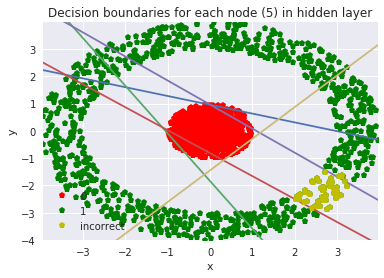

In [18]:
time run()